In [1]:
import os
os.listdir("../input/modelalexnet-and-best-weights-9/")

['best_weights_9.hdf5', 'AlexNetModel.hdf5']

In [2]:
# Importing Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization

# Initializing the CNN
classifier = Sequential()

# Convolution Step 1
classifier.add(Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(224, 224, 3), activation = 'relu'))

# Max Pooling Step 1
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())

# Convolution Step 2
classifier.add(Convolution2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))

# Max Pooling Step 2
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
classifier.add(BatchNormalization())

# Convolution Step 3
classifier.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 4
classifier.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 5
classifier.add(Convolution2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))

# Max Pooling Step 3
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())

# Flattening Step
classifier.add(Flatten())

# Full Connection Step
classifier.add(Dense(units = 4096, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 4096, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 1000, activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 38, activation = 'softmax'))
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 384)         8

In [3]:
classifier.load_weights('../input/modelalexnet-and-best-weights-9/best_weights_9.hdf5')

In [4]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
from keras import layers
for i, layer in enumerate(classifier.layers):
   print(i, layer.name)

0 conv2d
1 max_pooling2d
2 batch_normalization
3 conv2d_1
4 max_pooling2d_1
5 batch_normalization_1
6 conv2d_2
7 batch_normalization_2
8 conv2d_3
9 batch_normalization_3
10 conv2d_4
11 max_pooling2d_2
12 batch_normalization_4
13 flatten
14 dense
15 dropout
16 batch_normalization_5
17 dense_1
18 dropout_1
19 batch_normalization_6
20 dense_2
21 dropout_2
22 batch_normalization_7
23 dense_3


In [5]:
# we chose to train the top 2 conv blocks, i.e. we will freeze
# the first 8 layers and unfreeze the rest:
print("Freezed layers:")
for i, layer in enumerate(classifier.layers[:20]):
    print(i, layer.name)
    layer.trainable = False

Freezed layers:
0 conv2d
1 max_pooling2d
2 batch_normalization
3 conv2d_1
4 max_pooling2d_1
5 batch_normalization_1
6 conv2d_2
7 batch_normalization_2
8 conv2d_3
9 batch_normalization_3
10 conv2d_4
11 max_pooling2d_2
12 batch_normalization_4
13 flatten
14 dense
15 dropout
16 batch_normalization_5
17 dense_1
18 dropout_1
19 batch_normalization_6


In [6]:
#trainable parameters decrease after freezing some bottom layers   
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 384)         8

In [7]:
# Compiling the Model
from keras import optimizers
classifier.compile(optimizer=optimizers.SGD(lr=0.001, momentum=0.9, decay=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# image preprocessing
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 128
base_dir = "../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"

training_set = train_datagen.flow_from_directory(base_dir+'/train',
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=False)

valid_set = valid_datagen.flow_from_directory(base_dir+'/valid',
                                            target_size=(224, 224),
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [9]:
class_dict = training_set.class_indices
print(class_dict)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [10]:
li = list(class_dict.keys())
print(li)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [11]:
li = list(class_dict.keys())
print(li)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [12]:
train_num = training_set.samples
valid_num = valid_set.samples

In [13]:
# checkpoint
from keras.callbacks import ModelCheckpoint
weightpath = "best_weights_9.hdf5"
checkpoint = ModelCheckpoint(weightpath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
callbacks_list = [checkpoint]

#fitting images to CNN
history = classifier.fit_generator(training_set,
                         steps_per_epoch=150, #train_num//batch_size,
                         validation_data=valid_set,
                         epochs=10, #25,
                         validation_steps=100, #valid_num//batch_size,
                         callbacks=callbacks_list)
#saving model
filepath="AlexNetModel.hdf5"
classifier.save(filepath)

Epoch 1/10
150/150 [==============================] - 417s 3s/step - loss: 7.0892 - accuracy: 0.0561 - val_loss: 0.0822 - val_accuracy: 0.9717
Epoch 2/10
150/150 [==============================] - 345s 2s/step - loss: 5.8732 - accuracy: 0.0612 - val_loss: 0.0945 - val_accuracy: 0.9685
Epoch 3/10
150/150 [==============================] - 331s 2s/step - loss: 5.3996 - accuracy: 0.0636 - val_loss: 0.1110 - val_accuracy: 0.9645
Epoch 4/10
150/150 [==============================] - 321s 2s/step - loss: 5.1039 - accuracy: 0.0656 - val_loss: 0.1275 - val_accuracy: 0.9609
Epoch 5/10
150/150 [==============================] - 308s 2s/step - loss: 4.8865 - accuracy: 0.0745 - val_loss: 0.1389 - val_accuracy: 0.9602
Epoch 6/10
150/150 [==============================] - 298s 2s/step - loss: 4.7639 - accuracy: 0.0699 - val_loss: 0.1483 - val_accuracy: 0.9602
Epoch 7/10
150/150 [==============================] - 300s 2s/step - loss: 4.6131 - accuracy: 0.0775 - val_loss: 0.1589 - val_accuracy: 0.9598

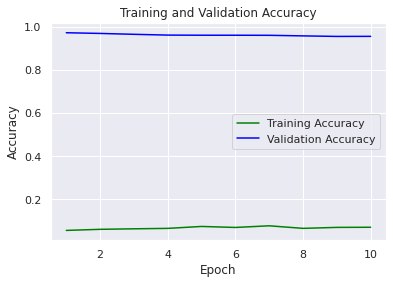

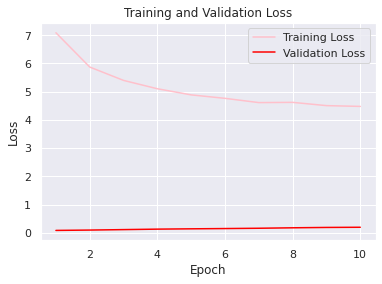

In [14]:
#plotting training values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Following is our prediction:


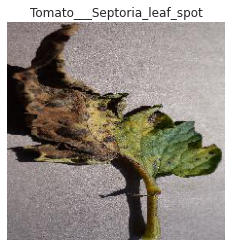

In [15]:
# predicting an image
from keras.preprocessing import image
import numpy as np
image_path = "../input/new-plant-diseases-dataset/test/test/TomatoEarlyBlight1.JPG"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = classifier.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

##Another way
# img_class = classifier.predict_classes(img)
# img_prob = classifier.predict_proba(img)
# print(img_class ,img_prob )


#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()

Following is our prediction:


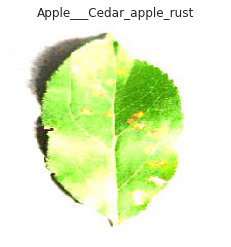

In [16]:
# predicting an image
from keras.preprocessing import image
import numpy as np
image_path = "../input/new-plant-diseases-dataset/test/test/AppleCedarRust1.JPG"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = classifier.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

##Another way
# img_class = classifier.predict_classes(img)
# img_prob = classifier.predict_proba(img)
# print(img_class ,img_prob )


#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()

In [17]:
# reset the test_data to start iterating over dataset from scratch
valid_set.reset()
# start to predict
pred = classifier.predict(valid_set)

In [18]:
import tensorflow as tf
import pandas as pd
# use the confusion_matrix function provided by tensorflow to generate confusion matrix
con_mat = tf.math.confusion_matrix(labels=valid_set.classes, predictions=np.argmax(pred, axis=1)).numpy()

# normalize the confusion matrix
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

# convert the nomalized confusion matrix for better view
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = valid_set.class_indices.keys(), 
                     columns = valid_set.class_indices.keys())

# show the nomalized confusion matrix
con_mat_df

,Apple___Apple_scab,Apple___Black_rot,Apple___Cedar_apple_rust,Apple___healthy,Blueberry___healthy,Cherry_(including_sour)___Powdery_mildew,Cherry_(including_sour)___healthy,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,Corn_(maize)___Common_rust_,Corn_(maize)___Northern_Leaf_Blight,...,Tomato___Bacterial_spot,Tomato___Early_blight,Tomato___Late_blight,Tomato___Leaf_Mold,Tomato___Septoria_leaf_spot,Tomato___Spider_mites Two-spotted_spider_mite,Tomato___Target_Spot,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato___Tomato_mosaic_virus,Tomato___healthy
Apple___Apple_scab,0.59,0.03,0.00,0.15,0.01,0.00,0.00,0.00,0.00,0.00,...,0.02,0.00,0.01,0.13,0.00,0.00,0.00,0.00,0.00,0.00
Apple___Black_rot,0.00,0.92,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Apple___Cedar_apple_rust,0.00,0.00,0.98,0.00,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Apple___healthy,0.00,0.00,0.00,0.97,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Blueberry___healthy,0.00,0.00,0.01,0.01,0.95,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Cherry_(including_sour)___Powdery_mildew,0.00,0.00,0.00,0.00,0.00,0.99,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Cherry_(including_sour)___healthy,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.86,0.01,0.12,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Corn_(maize)___Common_rust_,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.99,0.00,...,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Corn_(maize)___Northern_Leaf_Blight,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.98,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [19]:
# convert the original confusion matrix for better view (using the case numbers)
con_mat_df_explain = pd.DataFrame(con_mat,
                     index = valid_set.class_indices.keys(), 
                     columns = valid_set.class_indices.keys())

# show the unnomalized confusion matrix
con_mat_df_explain

,Apple___Apple_scab,Apple___Black_rot,Apple___Cedar_apple_rust,Apple___healthy,Blueberry___healthy,Cherry_(including_sour)___Powdery_mildew,Cherry_(including_sour)___healthy,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,Corn_(maize)___Common_rust_,Corn_(maize)___Northern_Leaf_Blight,...,Tomato___Bacterial_spot,Tomato___Early_blight,Tomato___Late_blight,Tomato___Leaf_Mold,Tomato___Septoria_leaf_spot,Tomato___Spider_mites Two-spotted_spider_mite,Tomato___Target_Spot,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato___Tomato_mosaic_virus,Tomato___healthy
Apple___Apple_scab,299,14,1,76,4,0,0,1,0,0,...,9,0,3,67,1,1,1,0,1,0
Apple___Black_rot,1,459,0,1,0,0,18,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Apple___Cedar_apple_rust,0,0,430,0,3,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
Apple___healthy,0,0,0,489,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Blueberry___healthy,1,0,4,3,432,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
Cherry_(including_sour)___Powdery_mildew,1,0,1,1,0,416,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cherry_(including_sour)___healthy,0,0,0,0,0,0,455,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,0,0,2,0,0,0,0,352,5,48,...,0,0,0,0,0,0,0,0,0,0
Corn_(maize)___Common_rust_,0,0,0,0,0,0,0,1,472,1,...,0,0,3,0,0,0,0,0,0,0
Corn_(maize)___Northern_Leaf_Blight,0,0,0,0,0,0,0,3,4,469,...,0,0,0,0,0,0,0,0,0,0


In [20]:
import sklearn.metrics
# generate the clasification report by using the classification_report of sklearn package
report = sklearn.metrics.classification_report(valid_set.classes, np.argmax(pred, axis=1), target_names=valid_set.class_indices.keys())

# print the report
print(report)

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.59      0.74       504
                                 Apple___Black_rot       0.96      0.92      0.94       497
                          Apple___Cedar_apple_rust       0.95      0.98      0.96       440
                                   Apple___healthy       0.83      0.97      0.90       502
                               Blueberry___healthy       0.98      0.95      0.96       454
          Cherry_(including_sour)___Powdery_mildew       0.98      0.99      0.99       421
                 Cherry_(including_sour)___healthy       0.84      1.00      0.91       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.86      0.92       410
                       Corn_(maize)___Common_rust_       0.98      0.99      0.98       477
               Corn_(maize)___Northern_Leaf_Blight       0.90      0.98      0.